In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'
scratch = '/scratch/08811/aew492/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u
import astropy.cosmology.units as cu
import os
import sys
sys.path.insert(0, work)
from illustris_sim import IllustrisSim
import corrfunc_ls

We want to explore different cuts in (specific) SFR and stellar mass.

In [4]:
# initialize simulation and snapshot
sim = IllustrisSim('TNG300-1', redshift=1.)

In [5]:
# load the subhalo positions, star formation rate and stellar masses
sim.load_subfind_subhalos()
sim.load_stellar_mass()
sim.load_SFR()

In [6]:
idx_nonzero = (sim.stellar_mass > 0) & (sim.SFR > 0)
print(f'{sum(idx_nonzero)/len(idx_nonzero)*100:.2f}% of the {sim.nsubhalos} subhalos have nonzero stellar mass and SFR')

6.63% of the 17062792 subhalos have nonzero stellar mass and SFR


In [7]:
# from here on, take only the subhalos with nonzero stellar mass and SFR
subhalos_nonzero = sim.subhalo_info[idx_nonzero]
stellar_mass = sim.stellar_mass[idx_nonzero]
SFR = sim.SFR[idx_nonzero]

Text(0.5, 1.0, 'Subhalo SFR distribution')

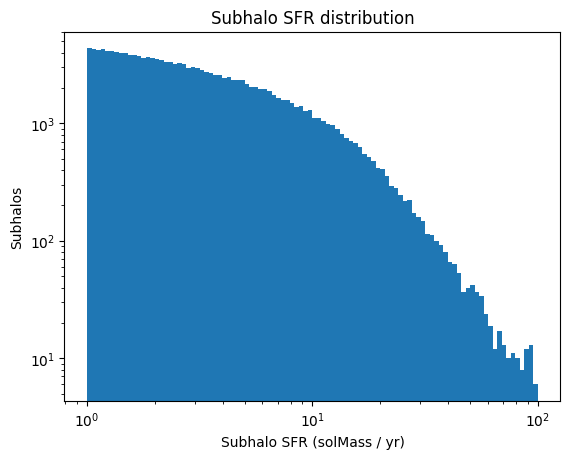

In [8]:
fig, ax = plt.subplots()
bins = np.logspace(0, 2, 101)
_, _, _ = ax.hist(SFR.value, bins=bins)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'Subhalo SFR ({SFR.unit})')
ax.set_ylabel('Subhalos')
ax.set_title('Subhalo SFR distribution')

In [9]:
# specific star formation rate (sSFR) = star formation rate per stellar mass
sSFR = SFR / stellar_mass

In [10]:
# per Sullivan, Prijon, & Seljak (2023), we'll try to take LRGs where log10(sSFR) < -9.09
LRG_cutval = -9.09
subhalos_LRG = subhalos_nonzero[np.log10(sSFR.value) < -9.09]

Text(0.5, 1.0, 'Subhalo sSFR distribution')

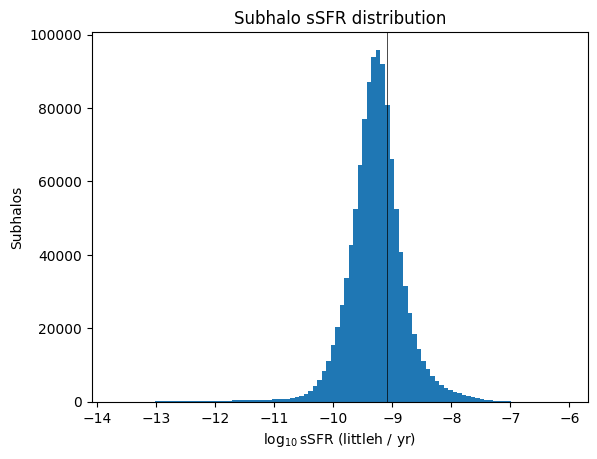

In [11]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(np.log10(sSFR.value), bins=100)
ax.axvline(LRG_cutval, lw=0.5, color='k')
ax.set_xlabel('$\log_{10}$sSFR'+f' ({sSFR.unit})')
ax.set_ylabel('Subhalos')
ax.set_title('Subhalo sSFR distribution')

#### target number density

In [12]:
V = 205**3 * (u.Mpc / cu.littleh)**3
num_den = 2e-4 * (u.Mpc / cu.littleh)**(-3)
target_n = int(V * num_den)
target_n, len(subhalos_LRG)

(1723, 790078)

In [13]:
# sort subhalos by decreasing stellar mass
idx_sorted = np.argsort(stellar_mass[np.log10(sSFR.value) < LRG_cutval])[::-1]
idx_sorted

array([   109,      0,    455, ..., 774388, 768786,  76296])

In [14]:
# then take only the first nsubhalos
galaxies = subhalos_LRG[idx_sorted][:target_n]

In [15]:
len(galaxies) / V

<Quantity 0.0002 littleh3 / Mpc3>

In [16]:
galaxy_pos = (galaxies['SubhaloPos'] * u.kpc).to(u.Mpc)

Text(0.5, 1.0, 'Galaxy positions, TNG300-1, z=1.00')

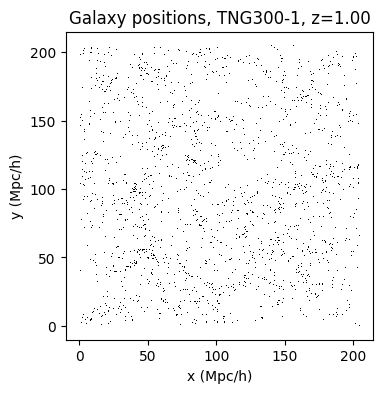

In [17]:
# 2D projection
fig, ax = plt.subplots(figsize=(4,4))

ax.plot(galaxy_pos[:,0], galaxy_pos[:,1], ls='None', marker=',', color='k')
ax.set_aspect('equal')
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_title(f'Galaxy positions, {sim.sim_tag}')

### compute galaxy autocorrelation

In [18]:
# parameters
randmult = 3
rmin = 1
rmax = 75.
nbins = 20
nthreads = 12
print(rmin, rmax, nbins)

1 75.0 20


In [19]:
len(galaxy_pos)

1723

In [20]:
%%time
nrepeats = 10
xi_gals = np.empty((nrepeats, nbins))
for j in range(nrepeats):
    ravg, xi_gals[j] = corrfunc_ls.compute_3D_ls_auto(galaxy_pos.value, randmult, rmin, rmax,
                                        nbins, logbins=True, periodic=True, nthreads=nthreads, prints=False)
xi_gal = np.mean(xi_gals, axis=0)

CPU times: user 2.11 s, sys: 36 ms, total: 2.15 s
Wall time: 1.04 s


In [21]:
# linear theory
xi_linear = sim.linear_2pcf(ravg)

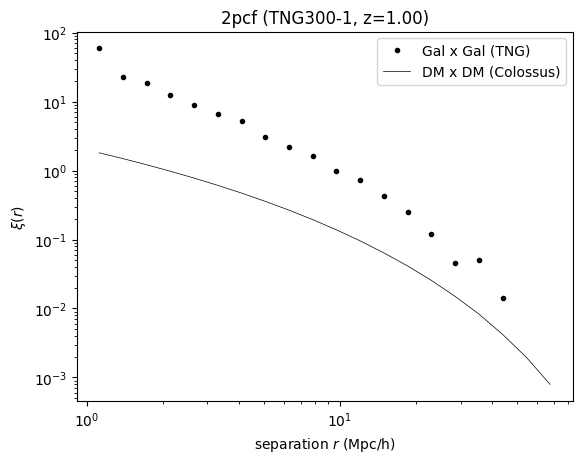

In [35]:
fig, ax = plt.subplots()

ax.plot(ravg, xi_gal, marker='.', ls='None', color='k', label='Gal x Gal (TNG)')
ax.plot(ravg, xi_linear, lw=0.5, color='k', label='DM x DM (Colossus)')
# ax.plot(xi_dm_auto['ravg'], xi_dm_auto['xi'], 'k.-', lw=0.5, label='DM x DM (1/10th subsample)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(f'2pcf ({sim.sim_tag})')
ax.legend()

In [23]:
bias = np.sqrt(xi_gal/xi_linear)

/tmp/ipykernel_3275655/1849772081.py:1: RuntimeWarning: invalid value encountered in sqrt
  bias = np.sqrt(xi_gal/xi_linear)


selection criteria:
 log10(sSFR) < -9.09 
 subhalos added in order of decreasing stellar mass until n = 2e-04


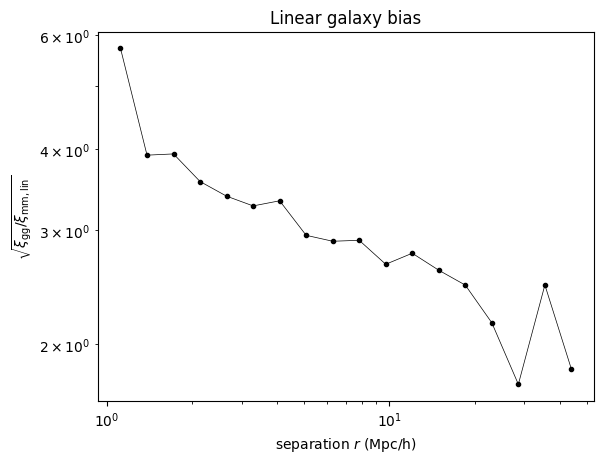

In [34]:
fig, ax = plt.subplots()
ax.plot(ravg, bias, 'k.-', lw=0.5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\sqrt{\xi_\mathrm{gg}/\xi_\mathrm{mm,lin}}$')
ax.set_title(f'Linear galaxy bias')

print(f'selection criteria:\n log10(sSFR) < {LRG_cutval} \n \
subhalos added in order of decreasing stellar mass until n = {num_den.value:.0e}')

In [32]:
np.nanmean(bias[ravg>4])

2.5601170711607035

In [28]:
min(np.log10(galaxies['SubhaloMassType'][:,4]))

1.0560645